<a href="https://colab.research.google.com/github/sabbir394/grad-cam-based-coherence-regularised/blob/main/grad_cam_based_coherence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
 # Download the dataset
!kaggle datasets download -d hamdallak/the-iqothnccd-lung-cancer-dataset

# Unzip the dataset
!unzip -q the-iqothnccd-lung-cancer-dataset.zip -d lung_cancer_data

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
Dataset URL: https://www.kaggle.com/datasets/hamdallak/the-iqothnccd-lung-cancer-dataset
License(s): CC0-1.0
 66% 98.0M/149M [00:00<00:00, 1.02GB/s]
100% 149M/149M [00:00<00:00, 804MB/s]  


In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-358fa7c1
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-358fa7c1
  Resolved https://github.com/qubvel/segmentation_models.git to commit 5d24bbfb28af6134e25e2c0b79e7727f6c0491d0
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00
  Created wheel for segmentation_models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33789 sha256=c127752733cff79127582b44e926e1d3a2d0e7fdce00ded5cc631b7e7b108e8b
  Stored in directory: /tmp/pip-ephem-wheel-cache-1hxpbryy/wheels/16/9b/76/6e33fba6f1888d8c6e0faf79bb28198229cb8dfab1a502558d
Successfully built segmentation_models


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

# === CLAHE Preprocessing ===
clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8, 8))
def apply_clahe(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return clahe.apply(img) if img is not None else None

# === Load Dataset ===
data_dir = "/content/lung_cancer_data/The IQ-OTHNCCD lung cancer dataset/"
subdirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
X, y = [], []
IMG_SIZE = 128

for subdir in subdirs:
    for path in glob(os.path.join(data_dir, subdir, "*.jpg")):
        img = apply_clahe(path)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(img)
            y.append(subdir)

X = np.expand_dims(np.array(X).astype("float32") / 255.0, -1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)

# === Multi-Glimpse Cropping ===
def multi_glimpses(images, size):
    h, w = images.shape[1], images.shape[2]
    positions = [(0, 0), (0, w-size), (h-size, 0), (h-size, w-size), ((h-size)//2, (w-size)//2)]
    return [images[:, y:y+size, x:x+size, :] for y, x in positions]

GLIMPSE_SIZE = 124
X_train_crops = multi_glimpses(X_train, GLIMPSE_SIZE)
X_test_crops = multi_glimpses(X_test, GLIMPSE_SIZE)

# === CNN Model ===
def build_base(glimpse_size, num_classes):
    inp = Input(shape=(glimpse_size, glimpse_size, 1))
    x = Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D()(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    out = Dense(num_classes, activation='softmax')(x)
    return Model(inp, out)

base_model = build_base(GLIMPSE_SIZE, len(le.classes_))

print([layer.name for layer in base_model.layers])  # 🟢 Add this line here




['input_layer', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'flatten', 'dense', 'dropout', 'dense_1']


Epoch 1/30
Loss: Total=1.0006, CE=0.9992, Coherence=0.0137
Epoch 2/30
Loss: Total=0.5428, CE=0.5405, Coherence=0.0235
Epoch 3/30
Loss: Total=0.5773, CE=0.5735, Coherence=0.0382
Epoch 4/30
Loss: Total=0.2918, CE=0.2881, Coherence=0.0370
Epoch 5/30
Loss: Total=0.0953, CE=0.0927, Coherence=0.0267
Epoch 6/30
Loss: Total=0.2734, CE=0.2681, Coherence=0.0527
Epoch 7/30
Loss: Total=0.1593, CE=0.1555, Coherence=0.0383
Epoch 8/30
Loss: Total=0.0628, CE=0.0587, Coherence=0.0407
Epoch 9/30
Loss: Total=0.0406, CE=0.0355, Coherence=0.0510
Epoch 10/30
Loss: Total=0.0804, CE=0.0756, Coherence=0.0482
Epoch 11/30
Loss: Total=0.1735, CE=0.1701, Coherence=0.0347
Epoch 12/30
Loss: Total=0.0117, CE=0.0070, Coherence=0.0476
Epoch 13/30
Loss: Total=0.0085, CE=0.0020, Coherence=0.0653
Epoch 14/30
Loss: Total=0.0156, CE=0.0105, Coherence=0.0514
Epoch 15/30
Loss: Total=0.0089, CE=0.0041, Coherence=0.0484
Epoch 16/30
Loss: Total=0.0540, CE=0.0462, Coherence=0.0785
Epoch 17/30
Loss: Total=0.0161, CE=0.0107, Cohere

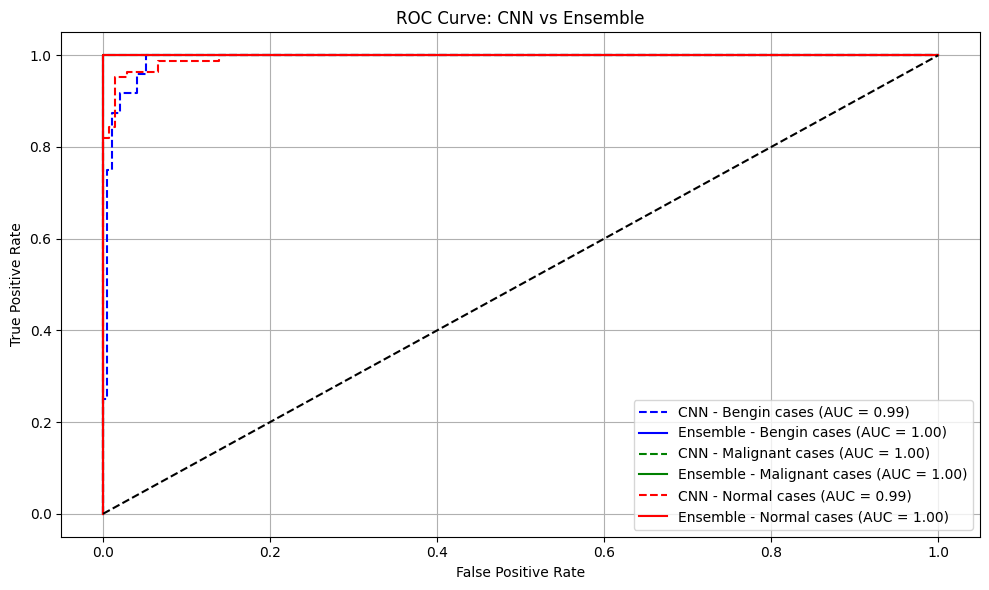

In [ ]:
# === Grad-CAM Tensor Function ===
def compute_gradcam_tensor(model, img, class_idx, layer_name="conv2d_2"):
    grad_model = tf.keras.Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    cam = tf.reduce_sum(tf.multiply(pooled_grads, conv_output[0]), axis=-1)
    cam = tf.nn.relu(cam)
    cam /= tf.reduce_max(cam + 1e-8)
    return cam

# === Coherence Loss Function ===
def coherence_loss_fn(model, crops, labels, layer_name="conv2d_2"):
    batch_size = labels.shape[0]
    total_loss = 0.0

    for i in range(batch_size):
        sample_crops = [tf.expand_dims(crop[i], axis=0) for crop in crops]
        class_idx = labels[i]
        cams = []

        for crop_img in sample_crops:
            cam = compute_gradcam_tensor(model, crop_img, class_idx, layer_name)
            cam_resized = tf.image.resize(cam[..., tf.newaxis], [32, 32])
            cams.append(cam_resized)

        ref_cam = cams[-1]  # center
        sample_loss = tf.add_n([tf.reduce_mean(tf.abs(cam - ref_cam)) for cam in cams[:-1]])
        total_loss += sample_loss / (len(cams) - 1)

    return total_loss / tf.cast(batch_size, tf.float32)


# === Custom Training Loop ===
@tf.function
def train_step_with_coherence(model, optimizer, x_crops, y_true, lambda_coherence=0.1):
    with tf.GradientTape() as tape:
        logits = model(x_crops[-1], training=True)
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, logits)
        ce_loss = tf.reduce_mean(ce_loss)
        coh_loss = coherence_loss_fn(model, x_crops, y_true)
        total_loss = ce_loss + lambda_coherence * coh_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return total_loss, ce_loss, coh_loss

# === Train with Coherence Regularization ===
optimizer = tf.keras.optimizers.Adam()
batch_size = 32
epochs = 30

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    indices = np.arange(len(y_train))
    np.random.shuffle(indices)
    for i in range(0, len(y_train), batch_size):
        idx = indices[i:i+batch_size]
        crop_batch = [tf.convert_to_tensor(crop[idx]) for crop in X_train_crops]
        y_batch = tf.convert_to_tensor(y_train[idx])
        total_loss, ce_loss, coh_loss = train_step_with_coherence(base_model, optimizer, crop_batch, y_batch)
    print(f"Loss: Total={total_loss:.4f}, CE={ce_loss:.4f}, Coherence={coh_loss:.4f}")

# === Predict with Average Over Crops ===
def average_predictions(model, crops):
    preds = [model.predict(crop) for crop in crops]
    return np.mean(preds, axis=0)

y_test_probs = average_predictions(base_model, X_test_crops)
y_pred_dl = np.argmax(y_test_probs, axis=1)

# === Feature Extraction for ML Ensemble ===
feature_model = Model(inputs=base_model.input, outputs=base_model.get_layer(index=-3).output)
X_train_feat = feature_model.predict(X_train_crops[-1])
X_test_feat = feature_model.predict(X_test_crops[-1])

# === Dimensionality Reduction ===
svd = TruncatedSVD(n_components=64)
X_train_svd = svd.fit_transform(X_train_feat)
X_test_svd = svd.transform(X_test_feat)

# === Traditional ML Ensemble ===
gnb = GaussianNB()
svm = SVC(probability=True)
rf = RandomForestClassifier()
ensemble = VotingClassifier(estimators=[('rf', rf), ('svm', svm), ('nb', gnb)], voting='soft')
ensemble.fit(X_train_svd, y_train)
y_pred_ensemble = ensemble.predict(X_test_svd)

# === Evaluation Reports ===
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

# === ROC Curves ===
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

fpr_dl, tpr_dl, auc_dl = {}, {}, {}
for i in range(n_classes):
    fpr_dl[i], tpr_dl[i], _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
    auc_dl[i] = roc_auc_score(y_test_bin[:, i], y_test_probs[:, i])

y_proba_ensemble = ensemble.predict_proba(X_test_svd)
fpr_ens, tpr_ens, auc_ens = {}, {}, {}
for i in range(n_classes):
    fpr_ens[i], tpr_ens[i], _ = roc_curve(y_test_bin[:, i], y_proba_ensemble[:, i])
    auc_ens[i] = roc_auc_score(y_test_bin[:, i], y_proba_ensemble[:, i])

plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red']
for i, cls in enumerate(le.classes_):
    plt.plot(fpr_dl[i], tpr_dl[i], linestyle='--', color=colors[i], label=f'CNN - {cls} (AUC = {auc_dl[i]:.2f})')
    plt.plot(fpr_ens[i], tpr_ens[i], linestyle='-', color=colors[i], label=f'Ensemble - {cls} (AUC = {auc_ens[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: CNN vs Ensemble')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_cnn_ensemble.png")
plt.show()


=== CNN Softmax Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.91      0.83      0.87        24
Malignant cases       0.97      1.00      0.99       113
   Normal cases       0.96      0.95      0.96        83

       accuracy                           0.96       220
      macro avg       0.95      0.93      0.94       220
   weighted avg       0.96      0.96      0.96       220

=== Ensemble Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       1.00      1.00      1.00        83

       accuracy                           1.00       220
      macro avg       1.00      1.00      1.00       220
   weighted avg       1.00      1.00      1.00       220



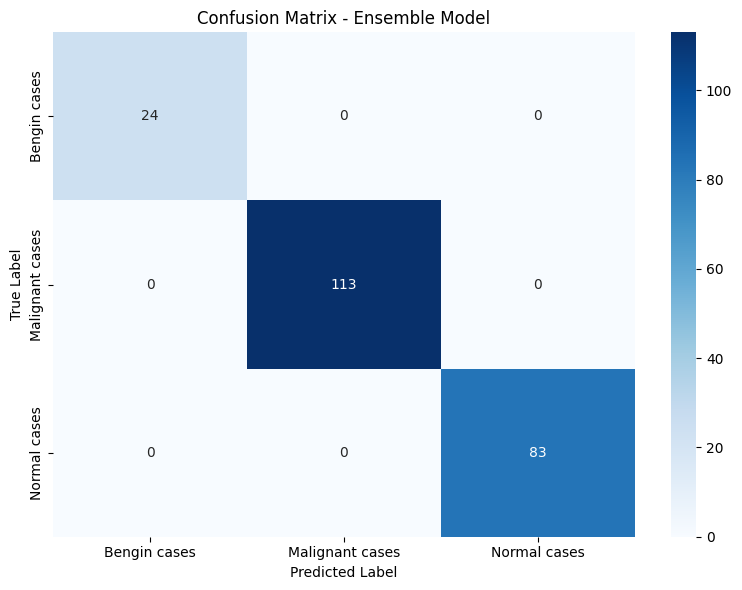

In [ ]:
# Add these imports at the beginning of your code
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Evaluation Reports ===
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))

# === Confusion Matrix for Ensemble ===
plt.figure(figsize=(8, 6))
conf_mat = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig("confusion_matrix_ensemble.png")
plt.show()

# === ROC Curves ===


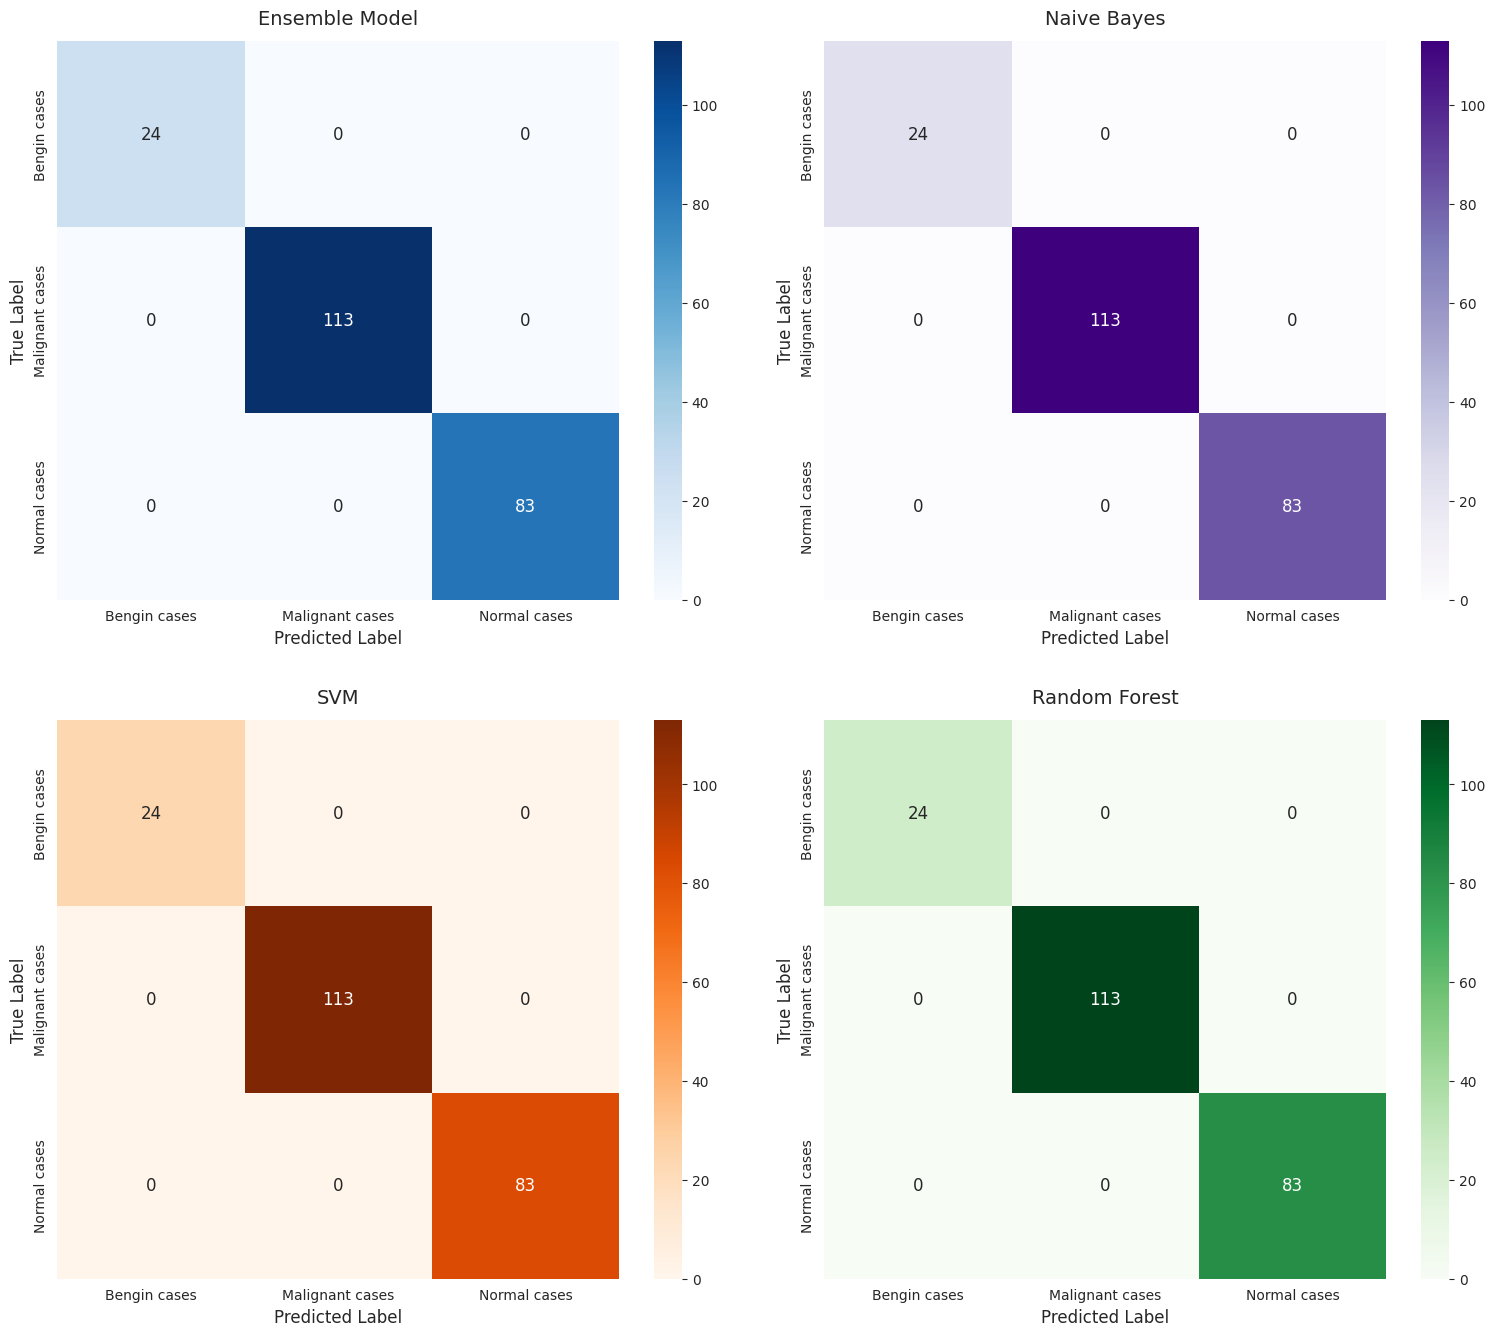

=== CNN Softmax Report ===
                 precision    recall  f1-score   support

   Bengin cases       0.91      0.83      0.87        24
Malignant cases       0.97      1.00      0.99       113
   Normal cases       0.96      0.95      0.96        83

       accuracy                           0.96       220
      macro avg       0.95      0.93      0.94       220
   weighted avg       0.96      0.96      0.96       220


=== Ensemble Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
Malignant cases       1.00      1.00      1.00       113
   Normal cases       1.00      1.00      1.00        83

       accuracy                           1.00       220
      macro avg       1.00      1.00      1.00       220
   weighted avg       1.00      1.00      1.00       220


=== Naive Bayes Report ===
                 precision    recall  f1-score   support

   Bengin cases       1.00      1.00      1.00        24
M

In [ ]:
# Import required libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create figure with 2x2 subplots
plt.figure(figsize=(16, 14))

# 1. Ensemble Model Confusion Matrix (Top Left)
plt.subplot(2, 2, 1)
conf_mat_ensemble = confusion_matrix(y_test, y_pred_ensemble)
sns.heatmap(conf_mat_ensemble, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Ensemble Model', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 2. Naive Bayes Confusion Matrix (Top Right)
plt.subplot(2, 2, 2)
conf_mat_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(conf_mat_nb, annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Naive Bayes', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 3. SVM Confusion Matrix (Bottom Left)
plt.subplot(2, 2, 3)
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('SVM', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# 4. Random Forest Confusion Matrix (Bottom Right)
plt.subplot(2, 2, 4)
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            annot_kws={"size": 12})
plt.title('Random Forest', fontsize=14, pad=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

# Adjust layout and save
plt.tight_layout(pad=3.0)
plt.savefig("all_confusion_matrices.png", dpi=300, bbox_inches='tight')
plt.show()

# Print classification reports
print("=== CNN Softmax Report ===")
print(classification_report(y_test, y_pred_dl, target_names=le.classes_))
print("\n=== Ensemble Report ===")
print(classification_report(y_test, y_pred_ensemble, target_names=le.classes_))
print("\n=== Naive Bayes Report ===")
print(classification_report(y_test, y_pred_nb, target_names=le.classes_))
print("\n=== SVM Report ===")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))
print("\n=== Random Forest Report ===")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

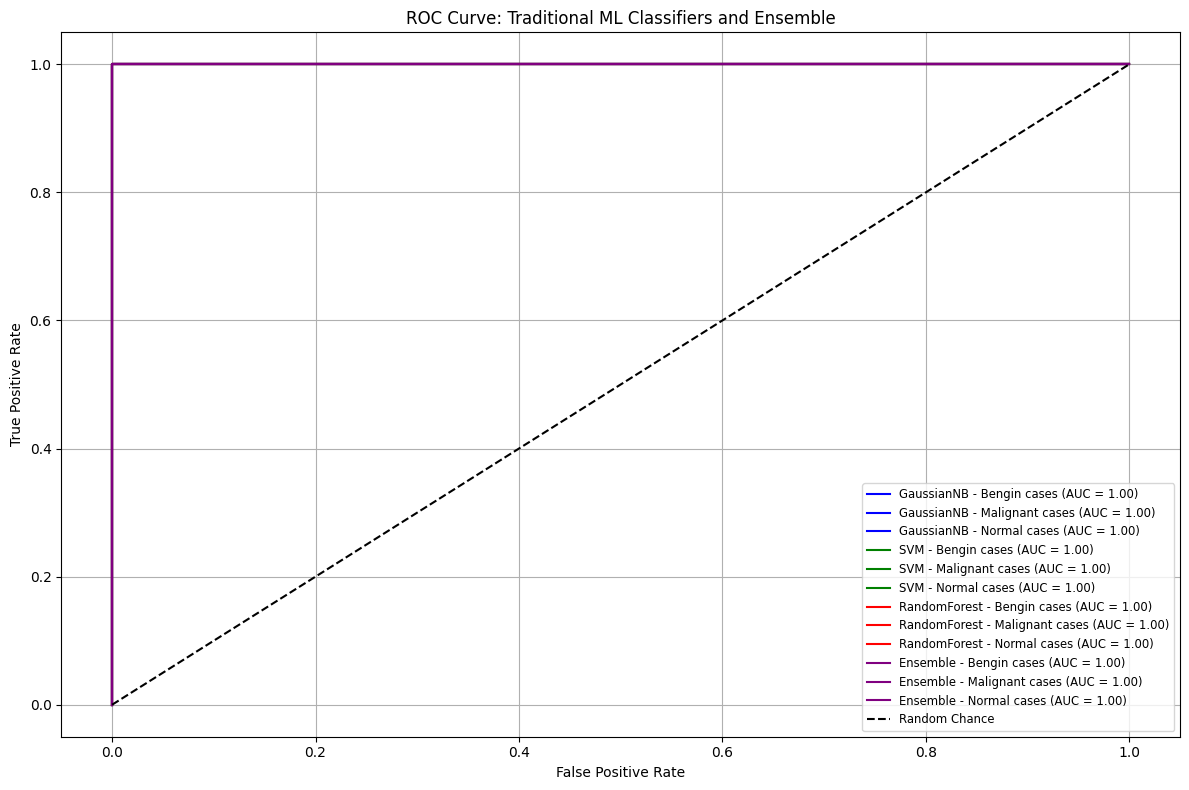

In [ ]:
# === Fit individual ML models ===
gnb.fit(X_train_svd, y_train)
svm.fit(X_train_svd, y_train)
rf.fit(X_train_svd, y_train)

# === ROC Curves: Traditional ML Classifiers & Ensemble ===
from sklearn.preprocessing import label_binarize

y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

ml_models = {
    'GaussianNB': gnb,
    'SVM': svm,
    'RandomForest': rf,
    'Ensemble': ensemble
}

roc_data = {}
for name, model in ml_models.items():
    y_proba = model.predict_proba(X_test_svd)
    fpr, tpr, auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        auc[i] = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    roc_data[name] = (fpr, tpr, auc)

# === Plot ROC Curves ===
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, (fpr, tpr, auc)) in enumerate(roc_data.items()):
    for i, cls in enumerate(le.classes_):
        plt.plot(fpr[i], tpr[i], linestyle='-', color=colors[idx],
                 label=f'{name} - {cls} (AUC = {auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Traditional ML Classifiers and Ensemble')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_ml_ensemble.png")
plt.show()


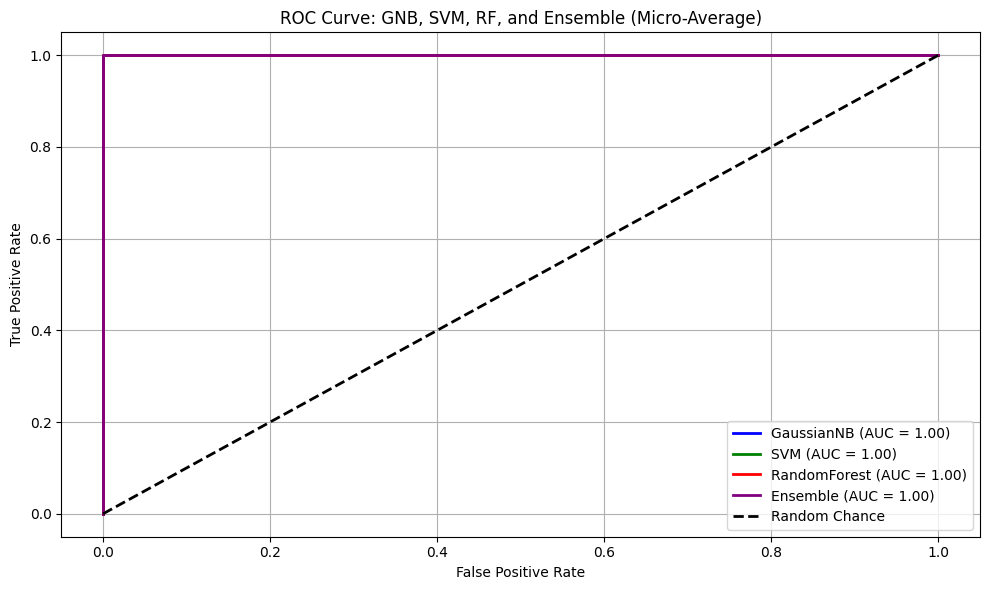

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Fit individual models
gnb.fit(X_train_svd, y_train)
svm.fit(X_train_svd, y_train)
rf.fit(X_train_svd, y_train)

# Binarize labels
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
n_classes = y_test_bin.shape[1]

# Dictionary of models
ml_models = {
    'GaussianNB': gnb,
    'SVM': svm,
    'RandomForest': rf,
    'Ensemble': ensemble
}

# ROC computation (micro-average)
roc_data = {}
for name, model in ml_models.items():
    y_score = model.predict_proba(X_test_svd)
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    roc_data[name] = (fpr, tpr, roc_auc)

# Plot ROC Curves
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple']
for idx, (name, (fpr, tpr, roc_auc)) in enumerate(roc_data.items()):
    plt.plot(fpr, tpr, color=colors[idx], lw=2,
             label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: GNB, SVM, RF, and Ensemble (Micro-Average)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_ml_ensemble_microavg.png")
plt.show()
